<a href="https://colab.research.google.com/github/dvd3110/Major_Project_2/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [9]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight

# TensorFlow / Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array  # Updated imports
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (Dense, Dropout, SpatialDropout2D, Activation, BatchNormalization,
                                     Lambda, Flatten, LSTM, Conv2D, MaxPooling2D,
                                     GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.applications import Xception

In [10]:
from google.colab import drive
drive.mount('/content/drive')

# Set paths to your dataset
train_folder = '/content/drive/MyDrive/dataset/train'
test_folder = '/content/drive/MyDrive/dataset/test'
validate_folder = '/content/drive/MyDrive/valid'


# # Print paths to verify
# print(f"Training data path: {TRAIN_PATH}")
# print(f"Validation data path: {VALID_PATH}")
# print(f"Testing data path: {TEST_PATH}")

Mounted at /content/drive


In [11]:
# Define dataset paths
train_folder = '/content/drive/MyDrive/dataset/train'
test_folder = '/content/drive/MyDrive/dataset/test'
validate_folder = '/content/drive/MyDrive/datasetvalid/valid'

In [12]:
# Set image size and batch size
IMAGE_SIZE = (299, 299)  # Xception's optimal input size
batch_size = 32  # Smaller batch size for better generalization

In [13]:
# Calculate steps per epoch correctly based on directory size
import os

def count_images(directory):
    """Count the total number of images in a directory with subdirectories"""
    total = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                total += 1
    return int(total)

In [14]:
# Count images in each dataset
train_images = count_images(train_folder)
test_images = count_images(test_folder)
valid_images = count_images(validate_folder)

In [15]:
# Calculate steps per epoch
steps_per_epoch = int(np.ceil(train_images / batch_size))
validation_steps = int(np.ceil(valid_images / batch_size))

In [16]:
# Debug prints to check types
print(f"Training images: {train_images} (type: {type(train_images)})")
print(f"Steps per epoch: {steps_per_epoch} (type: {type(steps_per_epoch)})")
print(f"Validation images: {valid_images} (type: {type(valid_images)})")
print(f"Validation steps: {validation_steps} (type: {type(validation_steps)})")

Training images: 613 (type: <class 'int'>)
Steps per epoch: 20 (type: <class 'int'>)
Validation images: 72 (type: <class 'int'>)
Validation steps: 3 (type: <class 'int'>)


In [17]:
# Enhanced image data generators with more augmentation for medical imaging
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotate up to 20 degrees
    width_shift_range=0.1,  # Shift width by up to 10%
    height_shift_range=0.1,  # Shift height by up to 10%
    shear_range=0.1,  # Shear by up to 10%
    zoom_range=0.1,  # Zoom by up to 10%
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.9, 1.1]  # Vary brightness slightly
)

In [18]:
# For validation, only rescale
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True
)

Found 613 images belonging to 4 classes.


In [20]:
validation_generator = validation_datagen.flow_from_directory(
    validate_folder,  # Use separate validation set
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False  # Don't shuffle validation data
)



Found 72 images belonging to 4 classes.


In [21]:
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data
)

Found 315 images belonging to 4 classes.


In [22]:
# Check class distribution and handle class imbalance
class_counts = np.unique(train_generator.classes, return_counts=True)
print("Class counts:", class_counts)

Class counts: (array([0, 1, 2, 3], dtype=int32), array([195, 115, 148, 155]))


In [23]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(0.7858974358974359), 1: np.float64(1.3326086956521739), 2: np.float64(1.035472972972973), 3: np.float64(0.9887096774193549)}


In [24]:
# Function to create and compile the model
def create_model(fine_tune_at=0):
    # Load pre-trained Xception model without top layers
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    )

    # Freeze the base model first
    base_model.trainable = False

    # Create the model
    inputs = base_model.input
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Strong dropout to prevent overfitting
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(len(train_generator.class_indices), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output_layer)

    # Unfreeze layers for fine-tuning if specified
    if fine_tune_at > 0:
        base_model.trainable = True

        # Freeze all the layers before the `fine_tune_at` layer
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

    return model


In [25]:
# Create model (initially with frozen base)
model = create_model()

# Compile with appropriate metrics
model.compile(
    optimizer=Adam(learning_rate=float(0.001)),  # Ensure learning rate is float
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print model summary
model.summary()

# Set up callbacks
model_checkpoint_path = 'best_model.keras'

# Setup callbacks for training
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

early_stops = EarlyStopping(
    monitor='val_loss',
    patience=7,  # More patience for medical images
    restore_best_weights=True,
    verbose=1
)

checkpointer = ModelCheckpoint(
    filepath=model_checkpoint_path,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    monitor='val_accuracy'
)

# Add TensorBoard callback for better monitoring
tensorboard_callback = TensorBoard(
    log_dir="./logs",
    histogram_freq=1,
    write_graph=True
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,922,860 (83.63 MB)

 Trainable params: 1,056,260 (4.03 MB)

 Non-trainable params: 20,866,600 (79.60 MB)

In [26]:
# Two-phase training: First train only the top layers
print("Phase 1: Training the top layers...")

# Debug: Print types of all objects being passed to fit
print(f"steps_per_epoch type: {type(steps_per_epoch)}")
print(f"validation_steps type: {type(validation_steps)}")
print(f"epochs type: {type(5)}")

# Extra check to ensure steps are integers
steps_per_epoch = int(steps_per_epoch)
validation_steps = int(validation_steps)

history1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,  # Start with fewer epochs for the first phase
    class_weight=class_weight_dict,  # Use class weights
    callbacks=[learning_rate_reduction, early_stops, checkpointer, tensorboard_callback],
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Phase 1: Training the top layers...
steps_per_epoch type: <class 'int'>
validation_steps type: <class 'int'>
epochs type: <class 'int'>
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5013 - auc: 0.7556 - loss: 1.4527 - precision: 0.5342 - recall: 0.4681 
Epoch 1: val_accuracy improved from -inf to 0.54167, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 389s 19s/step - accuracy: 0.5037 - auc: 0.7583 - loss: 1.4457 - precision: 0.5363 - recall: 0.4707 - val_accuracy: 0.5417 - val_auc: 0.7838 - val_loss: 1.0766 - val_precision: 0.8947 - val_recall: 0.2361 - learning_rate: 0.0010
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6532 - auc: 0.8731 - loss: 1.0507 - precision: 0.6682 - recall: 0.6388 
Epoch 2: val_accuracy improved from 0.54167 to 0.58333, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 347s 17s/step - accuracy: 0.6547 - auc: 0.8738 - loss: 1.0467 - precision: 0.6695 - recall: 0.6401 - val_accuracy: 0.5833 - val_auc: 0.83

In [27]:
# Second phase: Fine-tune the Xception model too
print("Phase 2: Fine-tuning Xception layers...")
# Unfreeze the base model
fine_tune_at = 100  # Number of layers to keep frozen (adjust based on your dataset size)
model = create_model(fine_tune_at=fine_tune_at)

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=float(0.0001)),  # Ensure learning rate is float
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Phase 2: Fine-tuning Xception layers...


In [28]:
# Extra check to ensure steps are integers
steps_per_epoch = int(steps_per_epoch)
validation_steps = int(validation_steps)

In [29]:
# Train again with fine-tuning
history2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=25,  # More epochs for fine-tuning
    class_weight=class_weight_dict,
    callbacks=[learning_rate_reduction, early_stops, checkpointer, tensorboard_callback],
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3717 - auc_1: 0.6089 - loss: 1.8525 - precision_1: 0.3677 - recall_1: 0.2786 
Epoch 1: val_accuracy did not improve from 0.75000
20/20 ━━━━━━━━━━━━━━━━━━━━ 527s 26s/step - accuracy: 0.3752 - auc_1: 0.6130 - loss: 1.8401 - precision_1: 0.3717 - recall_1: 0.2823 - val_accuracy: 0.4444 - val_auc_1: 0.7359 - val_loss: 1.2403 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.5834 - auc_1: 0.8348 - loss: 1.0929 - precision_1: 0.6120 - recall_1: 0.5383 
Epoch 2: val_accuracy did not improve from 0.75000
20/20 ━━━━━━━━━━━━━━━━━━━━ 556s 25s/step - accuracy: 0.5842 - auc_1: 0.8352 - loss: 1.0905 - precision_1: 0.6130 - recall_1: 0.5392 - val_accuracy: 0.5278 - val_auc_1: 0.8054 - val_loss: 1.1556 - val_precision_1: 1.0000 - val_recall_1: 0.0278 - learning_rate: 1.0000e-04
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.

In [30]:
# Combine histories for plotting
history = {}
for key in history1.history.keys():
    if key in history2.history.keys():
        history[key] = history1.history[key] + history2.history[key]

# Load the best model
model = load_model(model_checkpoint_path)

# Print final training and validation accuracy
print("Final training accuracy =", history['accuracy'][-1])
print("Final validation accuracy =", history['val_accuracy'][-1])


Final training accuracy = 0.975530207157135
Final validation accuracy = 0.8888888955116272


In [1]:

# Plot training and validation curves
def plot_training_history(history):
    plt.figure(figsize=(16, 8))

    # First find the correct AUC key names in the history dictionary
    auc_key = None
    val_auc_key = None
    for key in history.keys():
        if 'auc' in key.lower() and not 'val' in key.lower():
            auc_key = key
        if 'val' in key.lower() and 'auc' in key.lower():
            val_auc_key = key

    print(f"Available history keys: {list(history.keys())}")

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    # AUC plot - only if AUC keys are available
    plt.subplot(1, 3, 3)
    if auc_key and val_auc_key:
        plt.plot(history[auc_key], label='Train AUC')
        plt.plot(history[val_auc_key], label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
        plt.title('Model AUC')
    else:
        # If AUC keys not found, show precision instead
        precision_key = next((k for k in history.keys() if 'precision' in k.lower() and not 'val' in k.lower()), None)
        val_precision_key = next((k for k in history.keys() if 'precision' in k.lower() and 'val' in k.lower()), None)

        if precision_key and val_precision_key:
            plt.plot(history[precision_key], label='Train Precision')
            plt.plot(history[val_precision_key], label='Validation Precision')
            plt.xlabel('Epochs')
            plt.ylabel('Precision')
            plt.legend()
            plt.title('Model Precision')
        else:
            plt.text(0.5, 0.5, 'AUC/Precision metrics not found',
                    horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

NameError: name 'history' is not defined

In [33]:
# Save the trained model - THIS IS THE IMPORTANT PART THAT SAVES YOUR MODEL
model_save_path = '/content/drive/MyDrive/lung_cancer_model.keras'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/lung_cancer_model.keras


In [34]:
# Evaluate the model on test data
print("Evaluating on test data...")
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_generator, steps=int(np.ceil(test_images/batch_size)))
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

Evaluating on test data...
10/10 ━━━━━━━━━━━━━━━━━━━━ 152s 15s/step - accuracy: 0.8237 - auc_1: 0.9508 - loss: 0.5545 - precision_1: 0.8363 - recall_1: 0.8153
Test accuracy: 0.8571
Test AUC: 0.9678
Test precision: 0.8697
Test recall: 0.8476


In [35]:
# Get true labels and predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=int(np.ceil(test_images/batch_size)))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 149s 15s/step


In [36]:
# Class names mapping
class_names = list(test_generator.class_indices.keys())
print("Class indices:", test_generator.class_indices)

Class indices: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


Confusion Matrix:


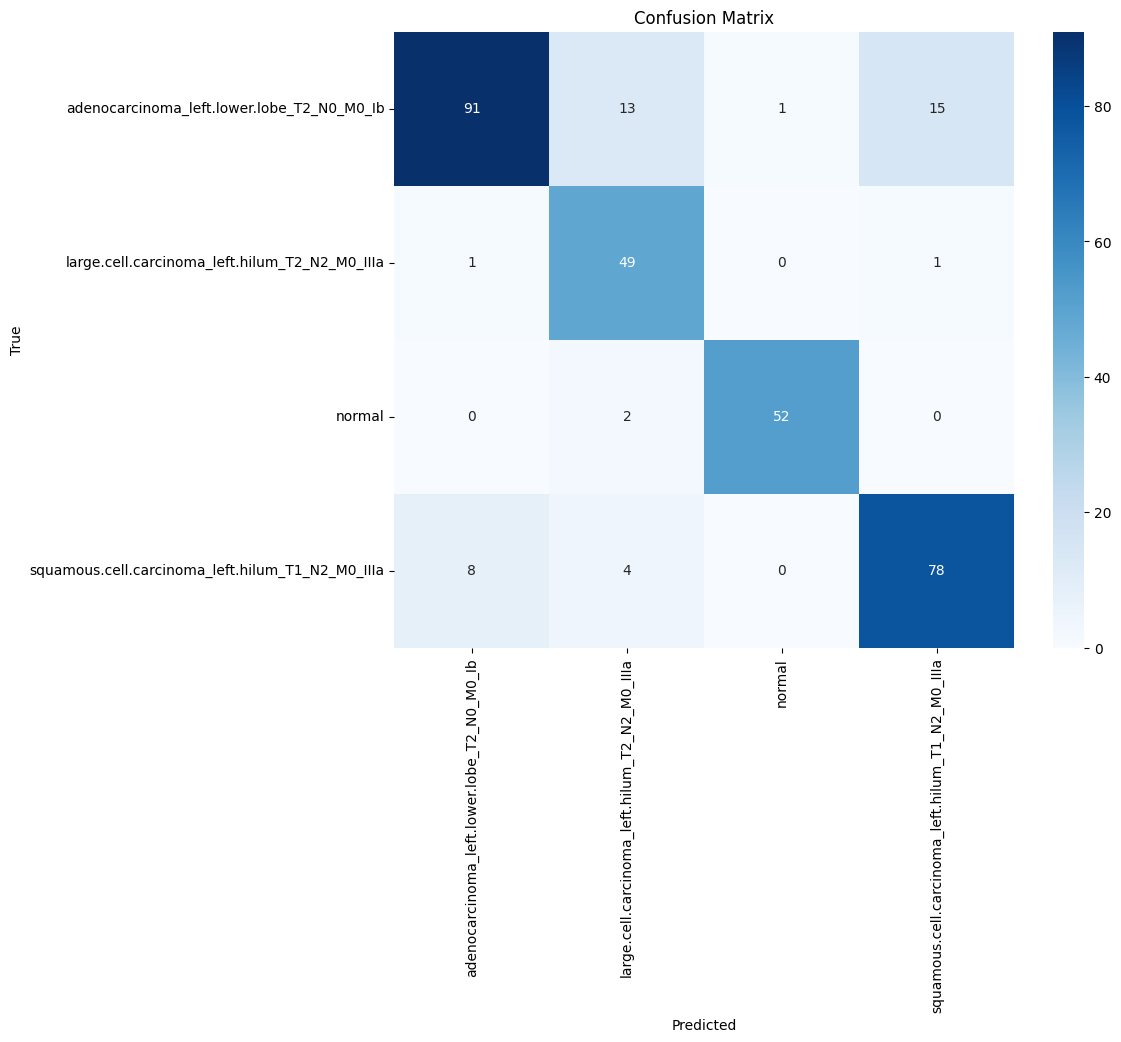

In [37]:
# Print confusion matrix and classification report
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.91      0.76      0.83       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.72      0.96      0.82        51
                                          normal       0.98      0.96      0.97        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.83      0.87      0.85        90

                                        accuracy                           0.86       315
                                       macro avg       0.86      0.89      0.87       315
                                    weighted avg       0.87      0.86      0.86       315



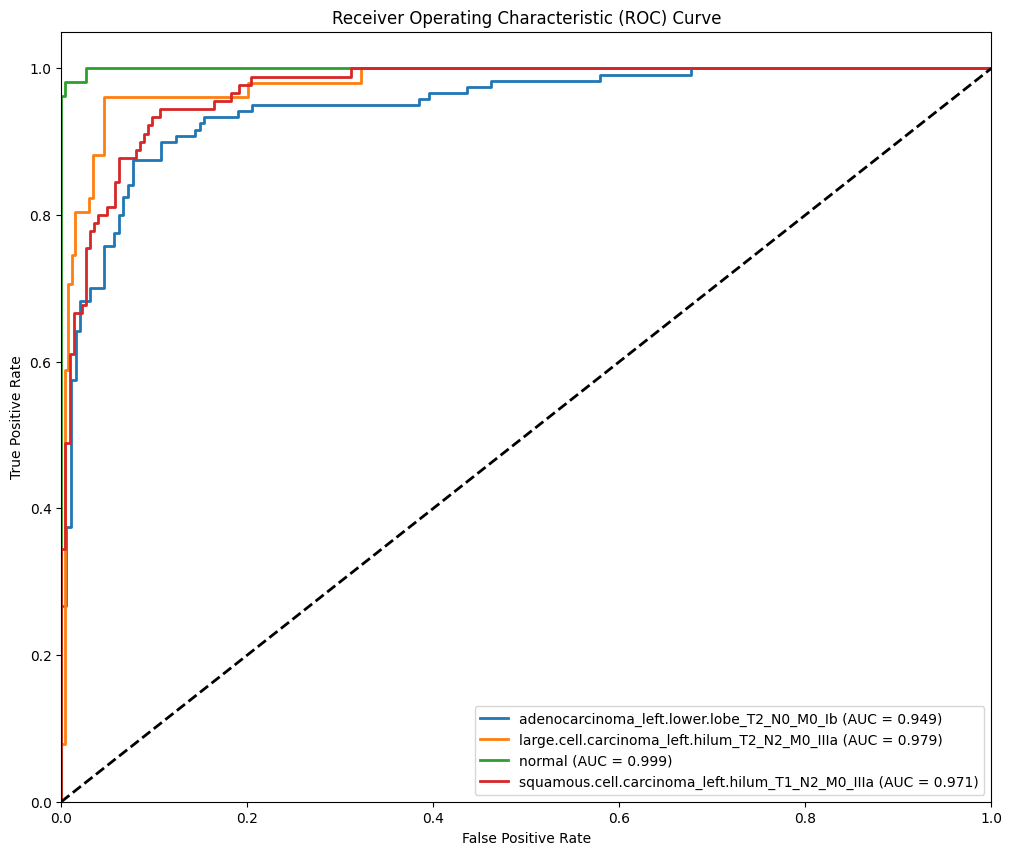

In [39]:
# Plot ROC curve for multi-class
plt.figure(figsize=(12, 10))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [40]:
# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize
    return img_array

In [41]:
# Function to predict and display an image with confidence scores
def predict_image(img_path):
    try:
        img = load_and_preprocess_image(img_path, IMAGE_SIZE)
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class] * 100

        class_labels = list(train_generator.class_indices.keys())
        predicted_label = class_labels[predicted_class]

        # Show image with predictions
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(load_img(img_path, target_size=IMAGE_SIZE))
        plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
        plt.axis('off')

        # Show confidence scores for all classes
        plt.subplot(1, 2, 2)
        bars = plt.barh(class_labels, predictions[0] * 100)
        plt.xlabel('Confidence (%)')
        plt.title('Prediction Confidence by Class')
        plt.xlim(0, 100)

        # Add percentage labels to bars
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
                    ha='left', va='center')

        plt.tight_layout()
        plt.show()

        return predicted_label, confidence
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None, None

Predictions on test images:

Predicting: /content/drive/MyDrive/dataset/test/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000109 (5).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


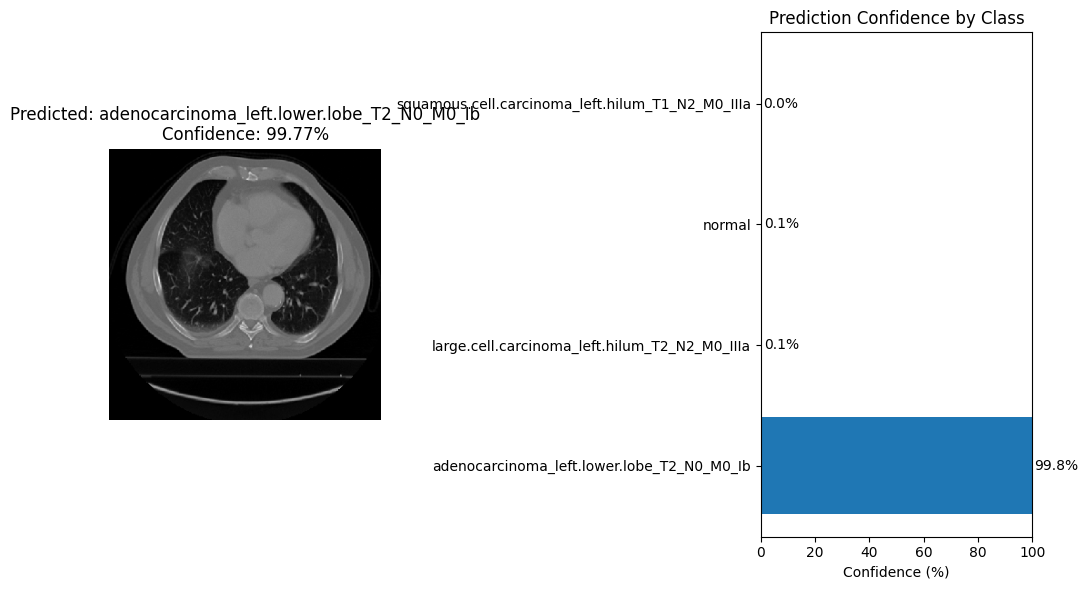

Predicted: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib with 99.77% confidence

Predicting: /content/drive/MyDrive/dataset/test/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000123 (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


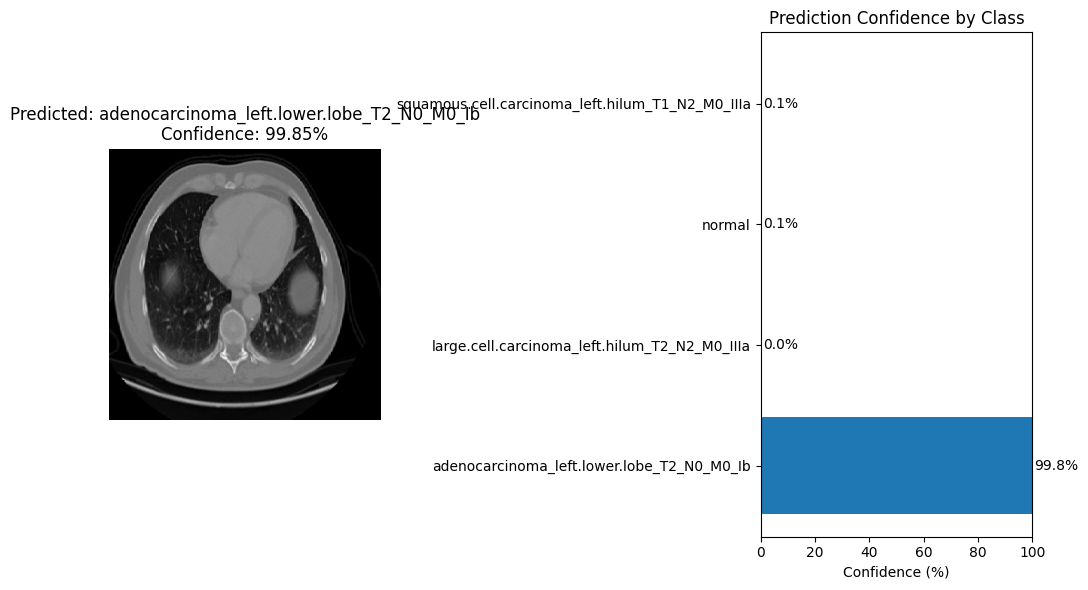

Predicted: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib with 99.85% confidence

Predicting: /content/drive/MyDrive/dataset/test/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000163 (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


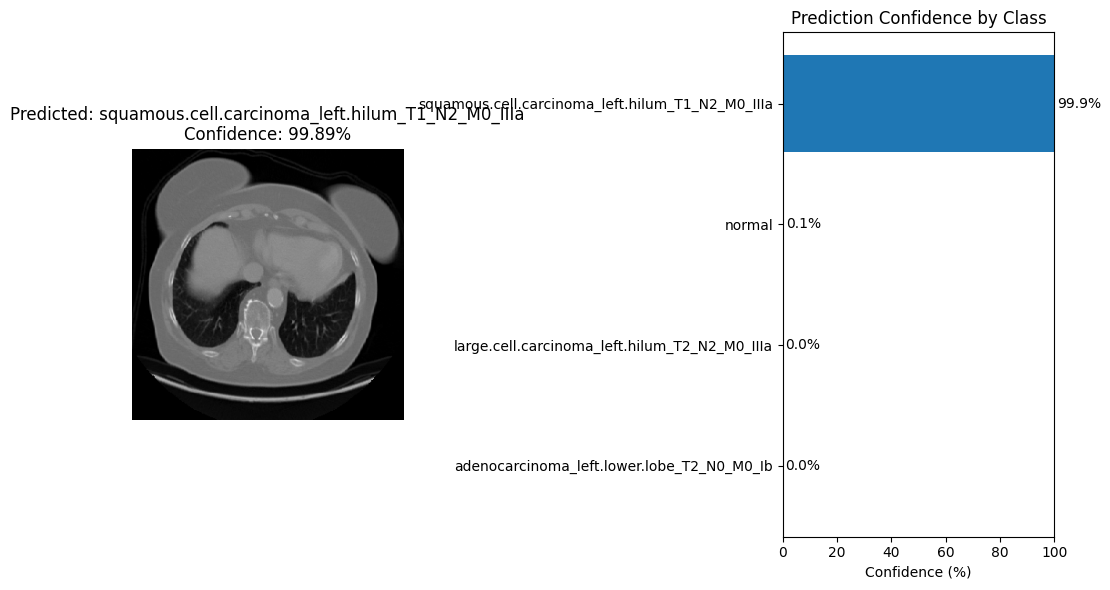

Predicted: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa with 99.89% confidence

Predicting: /content/drive/MyDrive/CTImages/000002 (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


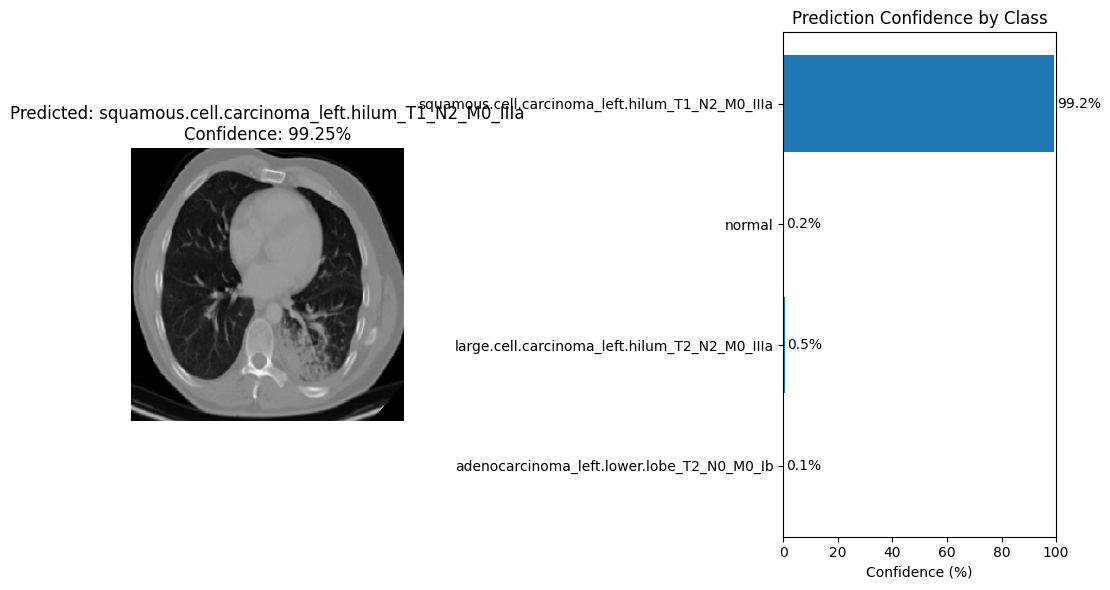

Predicted: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa with 99.25% confidence


In [42]:
# Test on specific images
print("Predictions on test images:")
test_images = [
    '/content/drive/MyDrive/dataset/test/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000109 (5).png',
    '/content/drive/MyDrive/dataset/test/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000123 (4).png',
    '/content/drive/MyDrive/dataset/test/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000163 (4).png',
    '/content/drive/MyDrive/CTImages/000002 (4).png'  # This path may need to be validated
]

for img_path in test_images:
    print(f"\nPredicting: {img_path}")
    label, confidence = predict_image(img_path)
    if label and confidence:
        print(f"Predicted: {label} with {confidence:.2f}% confidence")